In [1]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
from keras.initializers import Constant
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.python.ops import array_ops
from tqdm import tqdm
from keras import backend as K
import tensorflow as tf
import keras
from math import ceil, floor
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import log_loss
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten

2024-02-27 11:40:19.091799: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 11:40:19.091953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 11:40:19.214757: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_path = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'
test_image_dir = base_path + 'stage_2_test/'
train_image_dir= base_path + 'stage_2_train/'
train_df = pd.read_csv('../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv')
test_df = pd.read_csv('../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv')

## EDA

In [3]:
train_df

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0
...,...,...
4516837,ID_4a85a3a3f_intraparenchymal,0
4516838,ID_4a85a3a3f_intraventricular,0
4516839,ID_4a85a3a3f_subarachnoid,0
4516840,ID_4a85a3a3f_subdural,0


In [4]:
test_df

,ID,Label
0,ID_0fbf6a978_epidural,0.5
1,ID_0fbf6a978_intraparenchymal,0.5
2,ID_0fbf6a978_intraventricular,0.5
3,ID_0fbf6a978_subarachnoid,0.5
4,ID_0fbf6a978_subdural,0.5
...,...,...
727387,ID_6b455e140_intraparenchymal,0.5
727388,ID_6b455e140_intraventricular,0.5
727389,ID_6b455e140_subarachnoid,0.5
727390,ID_6b455e140_subdural,0.5


In [5]:
def read_train(train_df):
    train_df['type'] = train_df.ID.str.slice(start = 13) # 'ID' 열에서 13번째 문자부터 끝까지 추출해 'type'열 생성
    train_df['filename'] = train_df.ID.str.slice(stop = 12) # 'ID' 열에서 12번째 문자부터 끝까지 추출해 'filename'열 생성
    train_df = train_df.drop_duplicates()
    train_df = train_df.reset_index() # index 재설정
    train_df = train_df.drop('ID', axis =1) # 'ID'열 삭제
    train_df = train_df.set_index(['filename', 'type']).unstack(level=-1) # 'filename'과 'type'을 인덱스로 설정하고 'type'을 열로 변환해 df 재구성
    train_df = train_df.drop('index', axis =1) # 'index'열 삭제
    return train_df 

def read_test(test_df):
    test_df['type'] = test_df.ID.str.slice(start = 13)
    test_df['filename'] = test_df.ID.str.slice(stop = 12)
    test_df = test_df.drop_duplicates()
    test_df= test_df.drop('ID', axis =1)
    test_df = test_df.set_index(['filename', 'type']).unstack(level=-1)
    return test_df

In [6]:
train_df = read_train(train_df)
test_df = read_test(test_df)

In [7]:
train_df.head()

Label                                                          \
type           any epidural intraparenchymal intraventricular subarachnoid   
filename                                                                     
ID_000012eaf     0        0                0                0            0   
ID_000039fa0     0        0                0                0            0   
ID_00005679d     0        0                0                0            0   
ID_00008ce3c     0        0                0                0            0   
ID_0000950d7     0        0                0                0            0   

                       
type         subdural  
filename               
ID_000012eaf        0  
ID_000039fa0        0  
ID_00005679d        0  
ID_00008ce3c        0  
ID_0000950d7        0

In [8]:
test_df.head()

Label                                                          \
type           any epidural intraparenchymal intraventricular subarachnoid   
filename                                                                     
ID_000000e27   0.5      0.5              0.5              0.5          0.5   
ID_000009146   0.5      0.5              0.5              0.5          0.5   
ID_00007b8cb   0.5      0.5              0.5              0.5          0.5   
ID_000134952   0.5      0.5              0.5              0.5          0.5   
ID_000176f2a   0.5      0.5              0.5              0.5          0.5   

                       
type         subdural  
filename               
ID_000000e27      0.5  
ID_000009146      0.5  
ID_00007b8cb      0.5  
ID_000134952      0.5  
ID_000176f2a      0.5

In [9]:
print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')

train_df shape: (752803, 6)
test_df shape: (121232, 6)


In [10]:
df = train_df.reset_index(level = 0)

In [11]:
df

filename Label                                             \
type                   any epidural intraparenchymal intraventricular   
0       ID_000012eaf     0        0                0                0   
1       ID_000039fa0     0        0                0                0   
2       ID_00005679d     0        0                0                0   
3       ID_00008ce3c     0        0                0                0   
4       ID_0000950d7     0        0                0                0   
...              ...   ...      ...              ...              ...   
752798  ID_ffff82e46     0        0                0                0   
752799  ID_ffff922b9     1        0                0                1   
752800  ID_ffffb670a     1        0                0                0   
752801  ID_ffffcbff8     0        0                0                0   
752802  ID_fffff9393     0        0                0                0   

                              
type   subarachnoid subdural  
0                 0        0  
1                 0        0  
2                 0        0  
3                 0        0  
4                 0        0  
...             ...      ...  
752798            0        0  
752799            0        0  
752800            1        0  
752801            0        0  
752802            0        0  

[752803 rows x 7 columns]

In [12]:
img_names = df['filename']

In [13]:
print(type(img_names))
img_names

<class 'pandas.core.series.Series'>


0         ID_000012eaf
1         ID_000039fa0
2         ID_00005679d
3         ID_00008ce3c
4         ID_0000950d7
              ...     
752798    ID_ffff82e46
752799    ID_ffff922b9
752800    ID_ffffb670a
752801    ID_ffffcbff8
752802    ID_fffff9393
Name: filename, Length: 752803, dtype: object

In [14]:
del df

## Visualization

In [15]:
def Visualize_Ten_Image(train_df, type1):
    row = 2
    col = 5
    fig = plt.figure(figsize = (15, 5))
    count = 0
    
    for i in range(len(train_df)):
        if train_df['Label'][type1][i] == 1:
            ds = pydicom.dcmread(train_image_dir + str(img_names[i] + '.dcm'))
            fig.add_subplot(row, col, count + 1)
            plt.suptitle(type1, fontsize = 20)
            plt.imshow(ds.pixel_array, cmap = plt.cm.bone)
            plt.axis('off')
            count += 1
            if count == 10:
                break

/tmp/ipykernel_27/1700293568.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if train_df['Label'][type1][i] == 1:


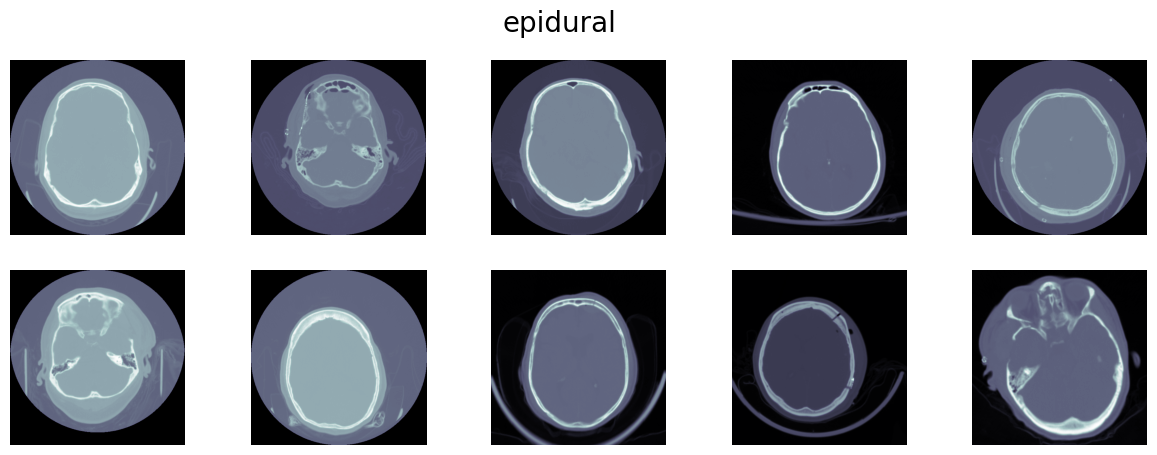

In [16]:
# 경막외 출혈
Visualize_Ten_Image(train_df, 'epidural')

/tmp/ipykernel_27/1700293568.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if train_df['Label'][type1][i] == 1:


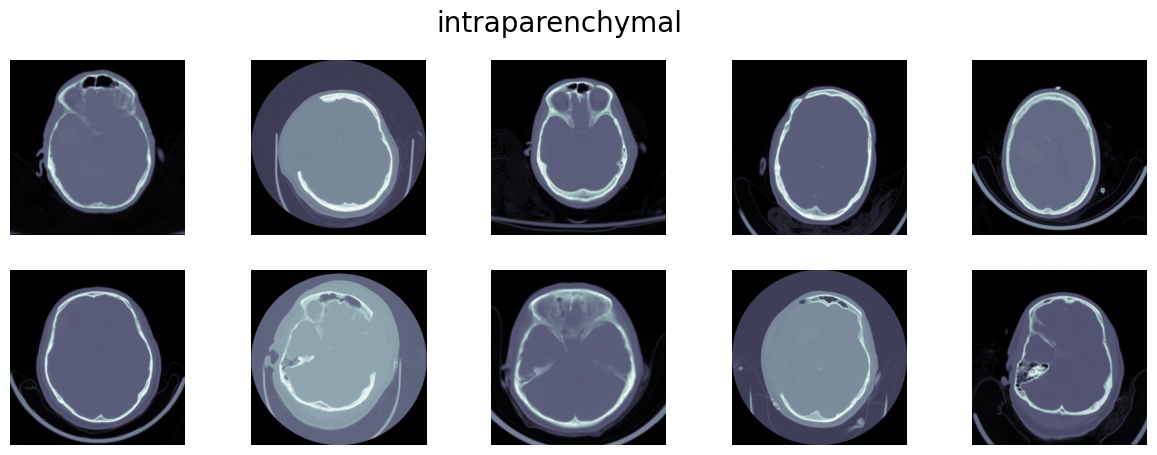

In [17]:
# 실질내 출혈
Visualize_Ten_Image(train_df, 'intraparenchymal')

/tmp/ipykernel_27/1700293568.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if train_df['Label'][type1][i] == 1:


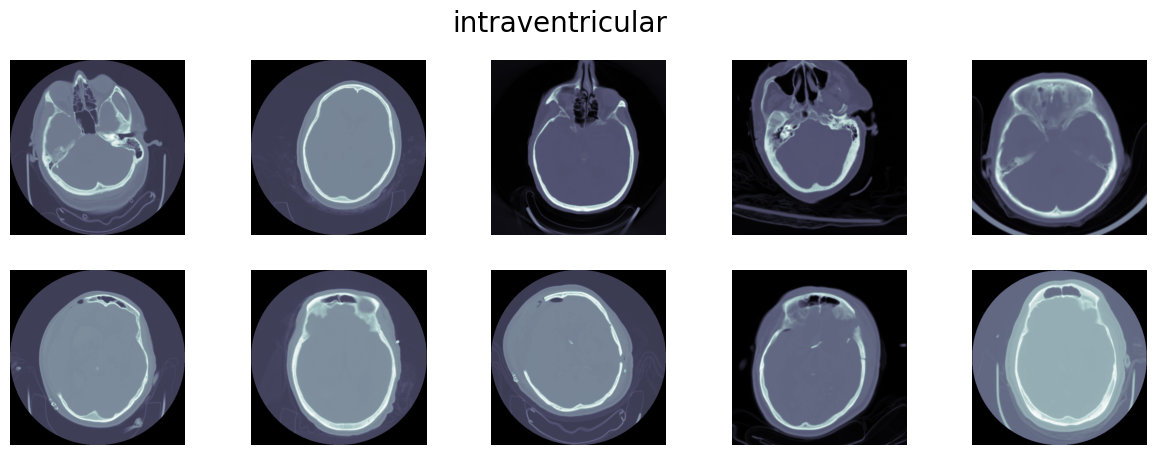

In [18]:
# 뇌실내 출혈
Visualize_Ten_Image(train_df, 'intraventricular')

/tmp/ipykernel_27/1700293568.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if train_df['Label'][type1][i] == 1:


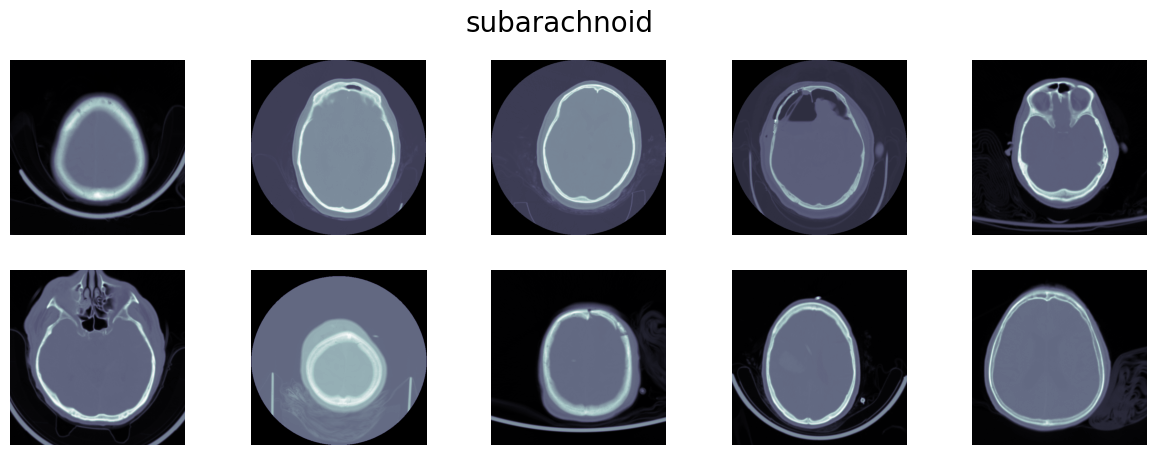

In [19]:
# 지주막 하 출혈
Visualize_Ten_Image(train_df, 'subarachnoid')

/tmp/ipykernel_27/1700293568.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if train_df['Label'][type1][i] == 1:


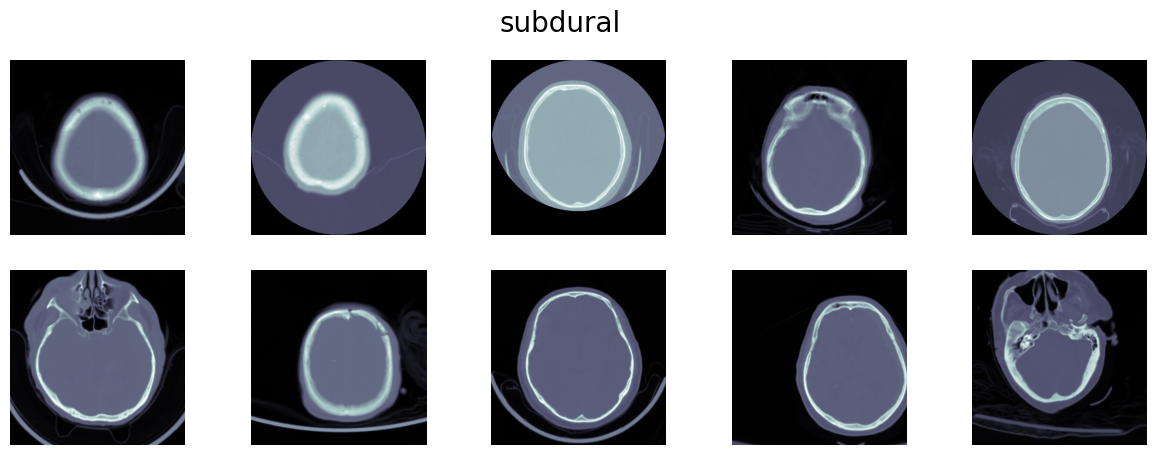

In [20]:
# 경막하 출혈
Visualize_Ten_Image(train_df, 'subdural')

/tmp/ipykernel_27/1700293568.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if train_df['Label'][type1][i] == 1:


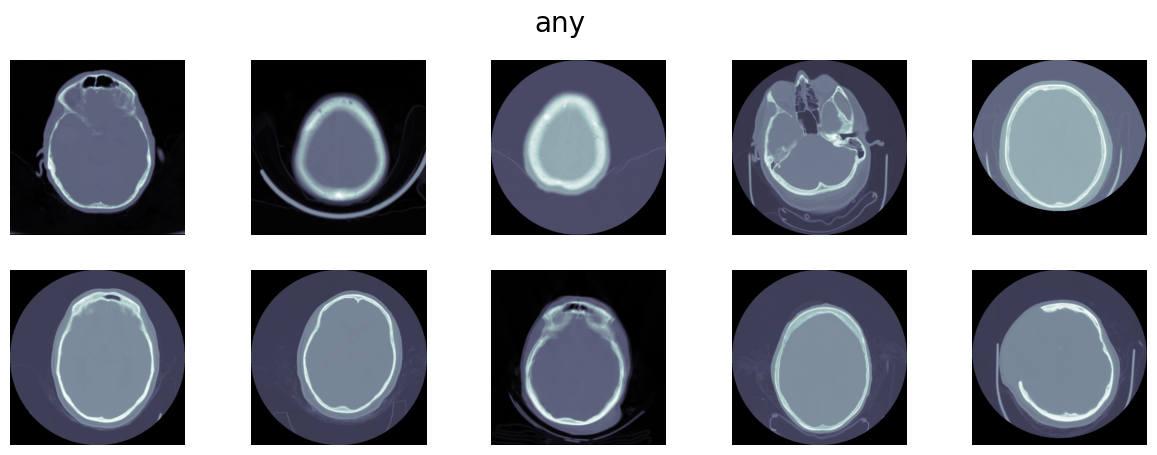

In [21]:
# 기타
Visualize_Ten_Image(train_df, 'any')

## Read Images and windowing

In [22]:
# dicom 객체를 가져와 픽셀 배열에 대한 보정을 수행
# 픽셀 배열에 1000을 더하고 임계값 이상의 값은 임계값을 뺌
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    # PixelData: DICOM 이미지의 픽셀 데이터를 나타내는 필드. 픽셀 데이터는 바이트로 표현되며, 픽셀 배열로 변환되어 처리
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000
    

# BitsStored: 이미지의 실제 비트 깊이를 나타내는 필드. 여기서는 12비트로 저장된 이미지임을 나타냄
# PixelRepresentation: 픽셀 값의 표현 방식을 나타내는 필드. 0일 경우 unsigned integer로 표현
# RescaleIntercept: 이미지의 픽셀 값에 적용되는 보정 계수(intercept)를 나타냄. 일반적으로 Hounsfield 단위를 DICOM 이미지의 픽셀 값으로 변환하는 데 사용
# RescaleSlope: 이미지의 픽셀 값에 적용되는 보정 계수(slope)를 나타냄. 이는 Hounsfield 단위를 DICOM 이미지의 픽셀 값으로 변환하는 데 사용

# dicom 객체와 윈도우의 중심과 너비를 사용해 이미지를 윈도우링(의료 영상에서 특정 관심 영역을 시각적으로 강조하는 기법)
def window_image(dcm, window_center, window_width):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    
    # Resize 
    img = cv2.resize(img, SHAPE[:2], interpolation = cv2.INTER_LINEAR)
    
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img
 
# dicom 객체를 가져와 뇌, 서두 및 연조직 윈도우링을 수행. 각 윈도우마다 다른 윈도우 중심과 너비가 사용  
def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80) #  윈도우의 중심은 40이고 폭은 80이므로, 해당 이미지의 값들은 40을 빼고 80으로 나누어서 정규화
    subdural_img = window_image(dcm, 80, 200) # 윈도우의 중심은 80이고 폭은 200이므로, 해당 이미지의 값들은 80을 빼고 200으로 나누어서 정규화
    soft_img = window_image(dcm, 40, 380) # 윈도우의 중심은 40이고 폭은 380이므로, 해당 이미지의 값들은 40을 빼고 380으로 나누어서 정규화
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1, 2, 0)
    return bsb_img

def _read(path, SHAPE):
    dcm = pydicom.dcmread(path)
    try:
        img = bsb_window(dcm)
    except:
        img = np.zeros(SHAPE)
    return img

## Create Data Generators

In [23]:
class Train_Val_Data_Generator(keras.utils.Sequence):
    def __init__(self, data, labels, batch_size = 32, img_size = (256, 256, 3), img_dir = train_image_dir, shuffle = False,*args, **kwargs):
        self.data = data
        self.ids = data.index
        self.labels = labels
        self.batch_size = batch_size
        self.img_dir = img_dir
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(ceil(len(self.ids) / self.batch_size))
    
    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X, Y = self.__data_generate(indices)
        return X, Y

    def on_epoch_end(self): # 각 epoch가 끝날 때마다 데이터를 셔플 
        self.indices = np.arange(len(self.ids))
        
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __data_generate(self, indices): # 지정된 인덱스에 해당하는 데이터와 라벨 생성 
        X = np.empty((self.batch_size, *self.img_size))
        Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
        for i, index in enumerate(indices):
            ID = self.ids[index]
            image = _read(str(self.img_dir)+str(ID)+".dcm", self.img_size)
            X[i,] = image
            Y[i,] = self.labels.iloc[index].values        
        return X, Y
    
# Train_Val 제너레이터랑 유사하지만 라벨이 없음
class Test_Data_Generator(keras.utils.Sequence):
    def __init__(self, data, labels, batch_size = 32, img_size = (256, 256, 3), img_dir = test_image_dir, *args, **kwargs):
        self.data = data
        self.ids = data.index
        self.labels = labels
        self.img_size = img_size
        self.batch_size = batch_size
        self.img_dir = img_dir
        self.on_epoch_end()
    
    def __len__(self):
        return int(ceil(len(self.ids) / self.batch_size))
    
    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X= self.__data_generate(indices)
        return X

    def on_epoch_end(self):
        
        self.indices = np.arange(len(self.ids))
        
    
    def __data_generate(self, indices):
            X = np.empty((self.batch_size, *self.img_size))
            
            for i, index in enumerate(indices):
                ID = self.ids[index]
                image = _read(str(self.img_dir)+str(ID)+".dcm", self.img_size)
                X[i,] = image
                return X

In [24]:
# ShuffleSplit은 scikit-learn 라이브러리에서 제공하는 교차 검증(cross-validation) 방법 중 하나
ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42).split(train_df.index)
train_idx, valid_idx = next(ss)

In [25]:
train_gen = Train_Val_Data_Generator(train_df.iloc[train_idx],
                                    train_df.iloc[train_idx],
                                    shuffle = False)

val_gen = Train_Val_Data_Generator(train_df.iloc[valid_idx], 
                                   train_df.iloc[valid_idx],
                                   shuffle = False)

test_gen = Test_Data_Generator(test_df, None,32, (256,256,3), test_image_dir,verbose =1)

In [26]:
inceptionv3 =tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
)

87910968/87910968 [==============================] - 3s 0us/step


## Create the Model

In [27]:
def build_model():
    print('Building Model')
    model = Sequential()
    model.add(inceptionv3)
    model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(6, activation = 'sigmoid'))
    
    model.compile(optimizer = keras.optimizers.Adam(), 
                  loss = 'binary_crossentropy',
                  metrics =  ['acc'])
    return model

model = build_model()
    
print(f'Model Summary: {model.summary()} ')

Building Model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 conv2d_94 (Conv2D)          (None, 4, 4, 64)          1179712   
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 2, 2, 64)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 2, 2, 64)          0         
                                                                 
 global_average_pooling2d (  (None, 64)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 64)  

In [28]:
TRAIN_STEPS = int(len(train_gen) / 32)
TRAIN_STEPS

661

## Callbacks

In [29]:
Early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=1, 
                                              mode='auto', baseline=None, restore_best_weights=False)
# monitor = 모니터링할 지표, min_delta = 개선을 감지위한 최소 변화량(0이므로 아무 변화도 감지되지 않을 때 조기종료), 
# patience = 조기종료를 위해 대기할 에포크 횟수, verbose = 진행상황을 출력할지 여부, mode = 모니터링 지표의 개선을 확인하기 위한 방법을 지정
# baseline = 개선을 판단하기 위한 기준값, restore_best_weights = 최적의 가중치를 복원할지 여부 

In [30]:
# 모델 학습 코드
model.fit_generator(generator = train_gen,
                    validation_data = val_gen,
                    steps_per_epoch = TRAIN_STEPS,
                    callbacks = [Early_stop],
                    epochs = 3)

/tmp/ipykernel_27/2228161061.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator = train_gen,


Epoch 1/3


2024-02-27 11:41:23.638371: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1709034092.183969      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


661/661 [==============================] - 1815s 3s/step - loss: 0.2299 - acc: 0.7431 - val_loss: 0.2066 - val_acc: 1.0000
Epoch 2/3
661/661 [==============================] - 1359s 2s/step - loss: 0.2096 - acc: 0.9542 - val_loss: 0.2066 - val_acc: 1.0000
Epoch 3/3
661/661 [==============================] - 1336s 2s/step - loss: 0.2124 - acc: 0.9958 - val_loss: 0.2025 - val_acc: 1.0000


## Inference

In [31]:
def predictions(test_df, model):    
    test_preds = model.predict_generator(test_gen, verbose = 1)
    return test_preds[:test_df.iloc[range(test_df.shape[0])].shape[0]]

In [32]:
submission_predictions =[]

In [33]:
preds = predictions(test_df, model)
submission_predictions.append(preds)

/tmp/ipykernel_27/1552442400.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_preds = model.predict_generator(test_gen, verbose = 1)


3789/3789 [==============================] - 316s 83ms/step


In [34]:
test_df.iloc[:, :] = np.average(submission_predictions, axis = 0, weights = [2**i for i in range(len(submission_predictions))])
test_df = test_df.stack().reset_index()
test_df.insert(loc = 0, column = 'ID', value = test_df['filename'].astype(str) + "_" + test_df['type'])
test_df = test_df.drop(["filename", "type"], axis=1)
test_df.to_csv('submission.csv', index = False)

print(test_df.head(12))

/tmp/ipykernel_27/4164110108.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  test_df = test_df.stack().reset_index()


                               ID     Label
0                ID_000000e27_any  0.146616
1           ID_000000e27_epidural  0.002842
2   ID_000000e27_intraparenchymal  0.039299
3   ID_000000e27_intraventricular  0.027015
4       ID_000000e27_subarachnoid  0.036191
5           ID_000000e27_subdural  0.056150
6                ID_000009146_any  0.146616
7           ID_000009146_epidural  0.002842
8   ID_000009146_intraparenchymal  0.039299
9   ID_000009146_intraventricular  0.027015
10      ID_000009146_subarachnoid  0.036191
11          ID_000009146_subdural  0.056150
